### This code provides: 

    1) Downloading the raw and 0D TNG100 SIM data for central galaxies at z=0 (version 4 of the dataset in this notebook, which includes galaxies with log10Mstar=8 and MHI and MH2 are usable features; v4 dataset does not include GroupBHMass (for more info see v3 updated notebook)) 
    2) Plotting the Spearman correlation for Raw Dataset
    3) Plotting the Spearman correlation for 0D Dataset

In [1]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

In [2]:
# the raw dataset
df_centrals_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')

# the dimensionless dataset; note that 0D v4 dataset is exactly the same as 0D v5 dataset, with the only difference
# in the feature names; in v4 features are labelled as _0D (for dimensionless=halo-scaled), while
# in v5 dataset features are labellede as _hs (halo-scaled=dimensionless) in order to be consisten with the 
# nomenclature Ari used in SAMs
df_centrals_0D =pd.read_csv('TNG-SIM_images/v3_initial_analysis/v5_TNG-SIM_0D_Dataset.csv')

### <font color='darkviolet'> <a id =7> </a> <br> Re-arrange features of the raw and 0D datasets so they are in the same order; translate feature names into paper names
    df_centrals_raw : the final Raw dataset used for ML
    df_centrals_0D : the final 0D dataset used for ML

In [16]:
df_centrals_raw.columns.to_list()

['SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloGasMetallicity',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'SubhaloMgas',
 'SubhaloMstar',
 'GroupNsubs',
 'Group_M_TopHat200',
 'Group_R_TopHat200',
 'SubhaloMHI',
 'SubhaloMH2',
 'Group_V_TopHat200',
 'GroupSpin_dmo']

In [17]:
df_centrals_0D.columns.to_list()

['SubhaloGasMetallicity',
 'SubhaloSFRinRad',
 'SubhaloStarMetallicity',
 'GroupNsubs',
 'GroupSpin_dmo',
 'SubhaloRstar_hs',
 'SubhaloRgas_hs',
 'SubhaloVmaxRad_hs',
 'SubhaloVmax_hs',
 'SubhaloVelDisp_hs',
 'SubhaloMgas_hs',
 'SubhaloMstar_hs',
 'SubhaloBHMass_hs',
 'SubhaloBHMdot_hs',
 'SubhaloMHI_hs',
 'SubhaloMH2_hs']

In [24]:
df_centrals_0D_arranged = df_centrals_0D[[ 'GroupNsubs',
                                        'SubhaloGasMetallicity', 'SubhaloStarMetallicity',
                      'SubhaloSFRinRad', 'SubhaloVelDisp_hs', 'SubhaloVmax_hs',
                      'SubhaloMHI_hs','SubhaloMH2_hs',
                      'SubhaloBHMass_hs', 'SubhaloBHMdot_hs',
                      'SubhaloMgas_hs','SubhaloMstar_hs',  
                      'SubhaloVmaxRad_hs', 'SubhaloRgas_hs', 'SubhaloRstar_hs',
                              'GroupSpin_dmo' ]         
 ]

In [26]:
df_centrals_raw_arranged = df_centrals_raw[[ 'Group_V_TopHat200', 'Group_R_TopHat200', 'Group_M_TopHat200',
                                        'GroupNsubs',
                                        'SubhaloGasMetallicity', 'SubhaloStarMetallicity',
                      'SubhaloSFRinRad', 'SubhaloVelDisp', 'SubhaloVmax',
                      'SubhaloMHI','SubhaloMH2',
                      'SubhaloBHMass', 'SubhaloBHMdot',
                      'SubhaloMgas','SubhaloMstar',  
                      'SubhaloVmaxRad', 'SubhaloRgas', 'SubhaloRstar',
                              'GroupSpin_dmo']]

In [27]:
df_centrals_raw_arranged.columns.to_list()

['Group_V_TopHat200',
 'Group_R_TopHat200',
 'Group_M_TopHat200',
 'GroupNsubs',
 'SubhaloGasMetallicity',
 'SubhaloStarMetallicity',
 'SubhaloSFRinRad',
 'SubhaloVelDisp',
 'SubhaloVmax',
 'SubhaloMHI',
 'SubhaloMH2',
 'SubhaloBHMass',
 'SubhaloBHMdot',
 'SubhaloMgas',
 'SubhaloMstar',
 'SubhaloVmaxRad',
 'SubhaloRgas',
 'SubhaloRstar',
 'GroupSpin_dmo']

In [25]:
df_centrals_0D_arranged.columns.to_list()

['GroupNsubs',
 'SubhaloGasMetallicity',
 'SubhaloStarMetallicity',
 'SubhaloSFRinRad',
 'SubhaloVelDisp_hs',
 'SubhaloVmax_hs',
 'SubhaloMHI_hs',
 'SubhaloMH2_hs',
 'SubhaloBHMass_hs',
 'SubhaloBHMdot_hs',
 'SubhaloMgas_hs',
 'SubhaloMstar_hs',
 'SubhaloVmaxRad_hs',
 'SubhaloRgas_hs',
 'SubhaloRstar_hs',
 'GroupSpin_dmo']

In [3]:
def translate_names(namelist,return_dictionary=False):
    '''translate to paper names'''
    feature_dict={'GroupSpin_dmo':'$\lambda$',
              'SubhaloBHMass':'$M_{BH}$', 'SubhaloBHMass_hs':'$M_{BH} / M_{vir}$',  
              'SubhaloBHMdot':'$\dot{M}_{BH}$', 'SubhaloBHMdot_hs':'$\dot{M}_{BH} / M_{vir}$',     
              'SubhaloGasMetallicity':'$Z_{cold}$',
              'SubhaloStarMetallicity':'$Z_{star}$',     
              'SubhaloSFRinRad':'SFR',  
            'SubhaloMHI':'$M_{HI}$','SubhaloMHI_hs':'$M_{HI} / M_{vir}$',
            'SubhaloMH2':'$M_{H2}$','SubhaloMH2_hs':'$M_{H2} / M_{vir}$',     
            'SubhaloMgas':'$M_{gas}$','SubhaloMgas_hs':'$M_{gas} / M_{vir}$',  
            'SubhaloMstar':'$M_{star}$', 'SubhaloMstar_hs':'$M_{star} / M_{vir}$',
                'SubhaloVelDisp':'$\sigma_vel$','SubhaloVelDisp_hs':'$\sigma_vel/v_{vir}$',
                'SubhaloVmax':'$V_{max}$', 'SubhaloVmax_hs':'$V_{max} / V_{vir}$',
             'SubhaloRstar':'$R_{star}$', 'SubhaloRstar_hs':'$R_{star} / R_{vir}$', 
             'SubhaloRgas':'$R_{gas}$', 'SubhaloRstar_hs':'$R_{gas} / R_{vir}$', 
             'SubhaloVmaxRad':'$R_{Vmax}$', 'SubhaloVmaxRad_hs':'$R_{Vmax} / R_{vir}$', 
                  'GroupNsubs':'$N_{subhalos}$',
            'Group_M_TopHat200':'$M_{vir}$',
            'Group_V_TopHat200':'$V_{vir}$',
            'Group_R_TopHat200':'$R_{vir}$',
                  }
    if return_dictionary:
        return feature_dict
    elif isinstance(namelist,str):
        return feature_dict(namelist)
    else:
        return [feature_dict[f] for f in namelist]

In [6]:
feature_names = str(df_centrals_raw.columns.to_list())

In [7]:
feature_names

"['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloGasMetallicity', 'SubhaloSFRinRad', 'SubhaloStarMetallicity', 'SubhaloVelDisp', 'SubhaloVmax', 'SubhaloVmaxRad', 'SubhaloRgas', 'SubhaloRstar', 'SubhaloMgas', 'SubhaloMstar', 'GroupNsubs', 'Group_M_TopHat200', 'Group_R_TopHat200', 'SubhaloMHI', 'SubhaloMH2', 'Group_V_TopHat200', 'GroupSpin_dmo']"

In [14]:
new_names = translate_names (feature_names, return_dictionary=False)

TypeError: 'dict' object is not callable

In [10]:
new_names

{'GroupSpin_dmo': '$\\lambda$',
 'SubhaloBHMass': '$M_{BH}$',
 'SubhaloBHMass_hs': '$M_{BH} / M_{vir}$',
 'SubhaloBHMdot': '$\\dot{M}_{BH}$',
 'SubhaloBHMdot_hs': '$\\dot{M}_{BH} / M_{vir}$',
 'SubhaloGasMetallicity': '$Z_{cold}$',
 'SubhaloStarMetallicity': '$Z_{star}$',
 'SubhaloSFRinRad': 'SFR',
 'SubhaloMHI': '$M_{HI}$',
 'SubhaloMHI_hs': '$M_{HI} / M_{vir}$',
 'SubhaloMH2': '$M_{H2}$',
 'SubhaloMH2_hs': '$M_{H2} / M_{vir}$',
 'SubhaloMgas': '$M_{gas}$',
 'SubhaloMgas_hs': '$M_{gas} / M_{vir}$',
 'SubhaloMstar': '$M_{star}$',
 'SubhaloMstar_hs': '$M_{star} / M_{vir}$',
 'SubhaloVelDisp': '$\\sigma_vel$',
 'SubhaloVelDisp_hs': '$\\sigma_vel/v_{vir}$',
 'SubhaloVmax': '$V_{max}$',
 'SubhaloVmax_hs': '$V_{max} / V_{vir}$',
 'SubhaloRstar': '$R_{star}$',
 'SubhaloRstar_hs': '$R_{gas} / R_{vir}$',
 'SubhaloRgas': '$R_{gas}$',
 'SubhaloVmaxRad': '$R_{Vmax}$',
 'SubhaloVmaxRad_hs': '$R_{Vmax} / R_{vir}$',
 'GroupNsubs': '$N_{subhalos}$',
 'Group_M_TopHat200': '$M_{vir}$',
 'Group_V_TopHat

### <font color='darkviolet'> <a id =7> </a> <br> Correlation Matrix of Raw and 0D dataset using only the features available for ML modelling

### <font color='DarkGreen'> Spearman Correlations of the complete Raw dataset

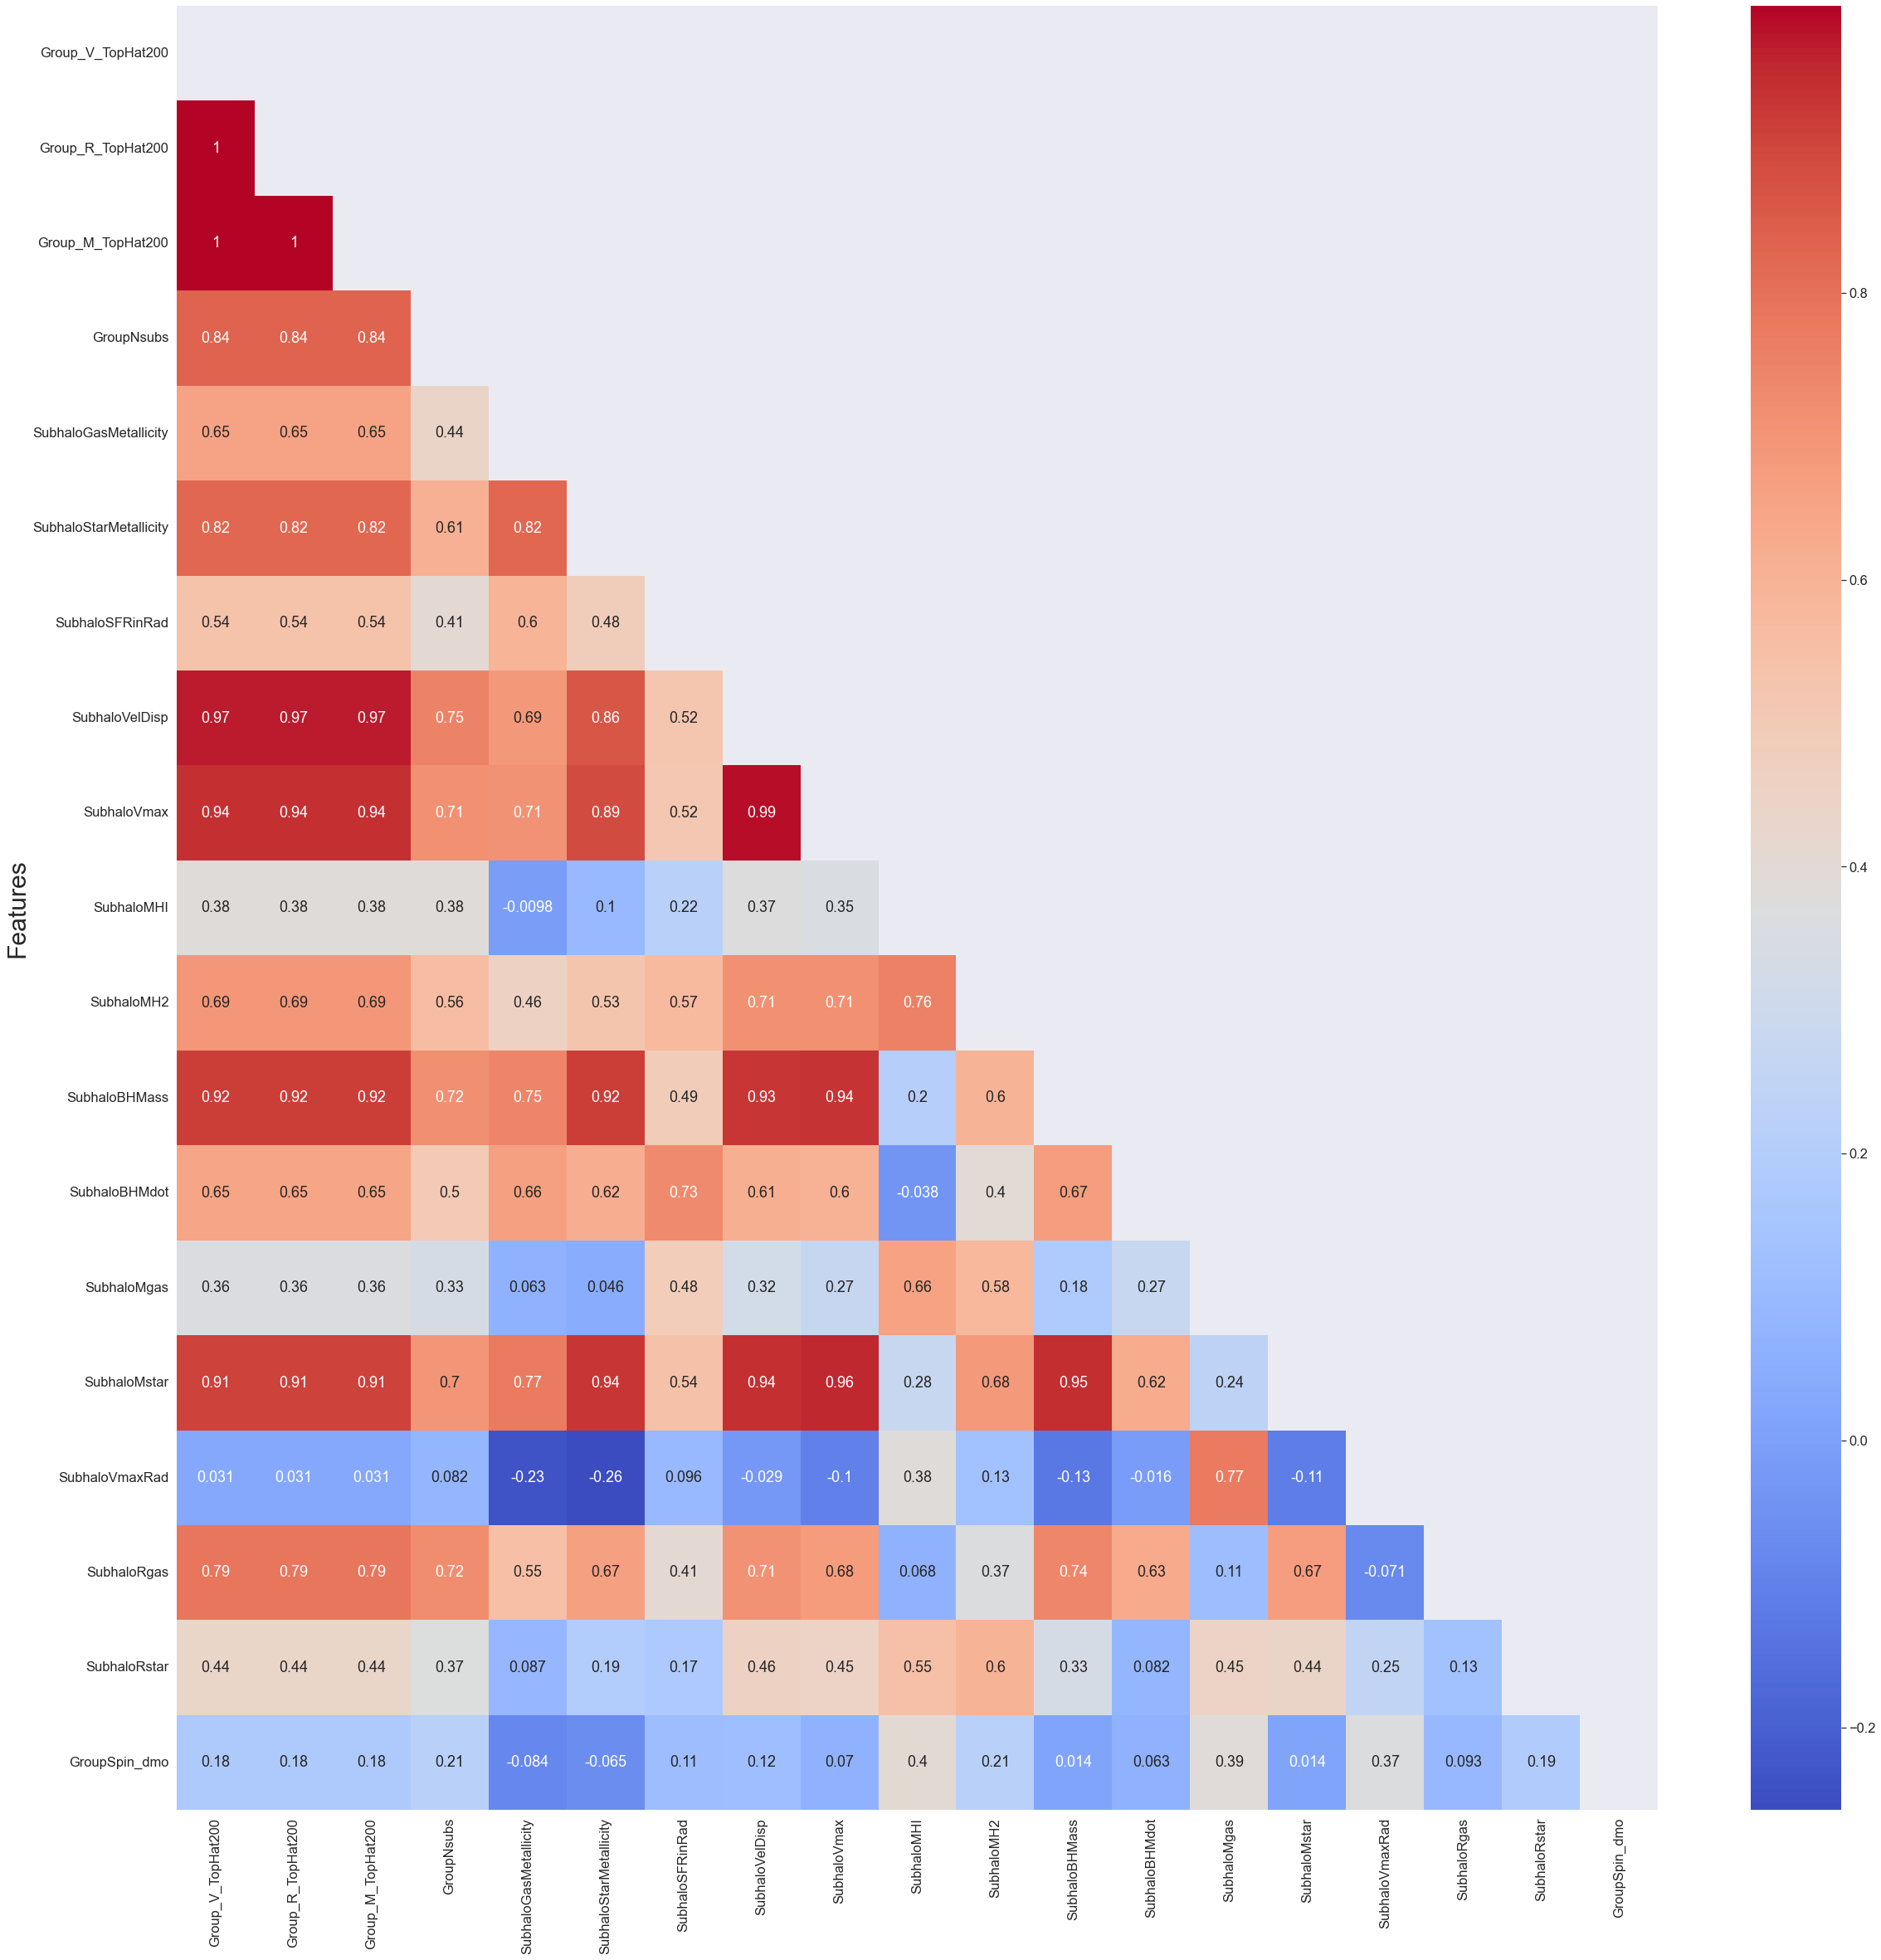

In [29]:
corr_df_raw = df_centrals_raw_arranged.corr('spearman')
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df_raw) # take upper correlation matrix
sns.heatmap(corr_df_raw,annot=True, mask=matrix, cmap="coolwarm", annot_kws={"size": 18}) #,
#             xticklabels=new_names, yticklabels=new_names)

# Q: How to change feature names from the ones in df_centrals_raw to paper names?

sns.set(font_scale=1.5)
# plt.title("Spearman Correlation of Raw TNG-SIM \n v3 Dataset w log10Mstar=8 gals included", fontsize = 20)
plt.ylabel("Features", fontsize = 30)
# plt.savefig('TNG-SIM_images/v14_updated_analysis/v14_TNG-SIM_Spearman_correlation_Raw_dataset.jpeg', dpi=500)
plt.show()


### <font color='DarkGreen'> Spearman Correlations of the complete 0D dataset

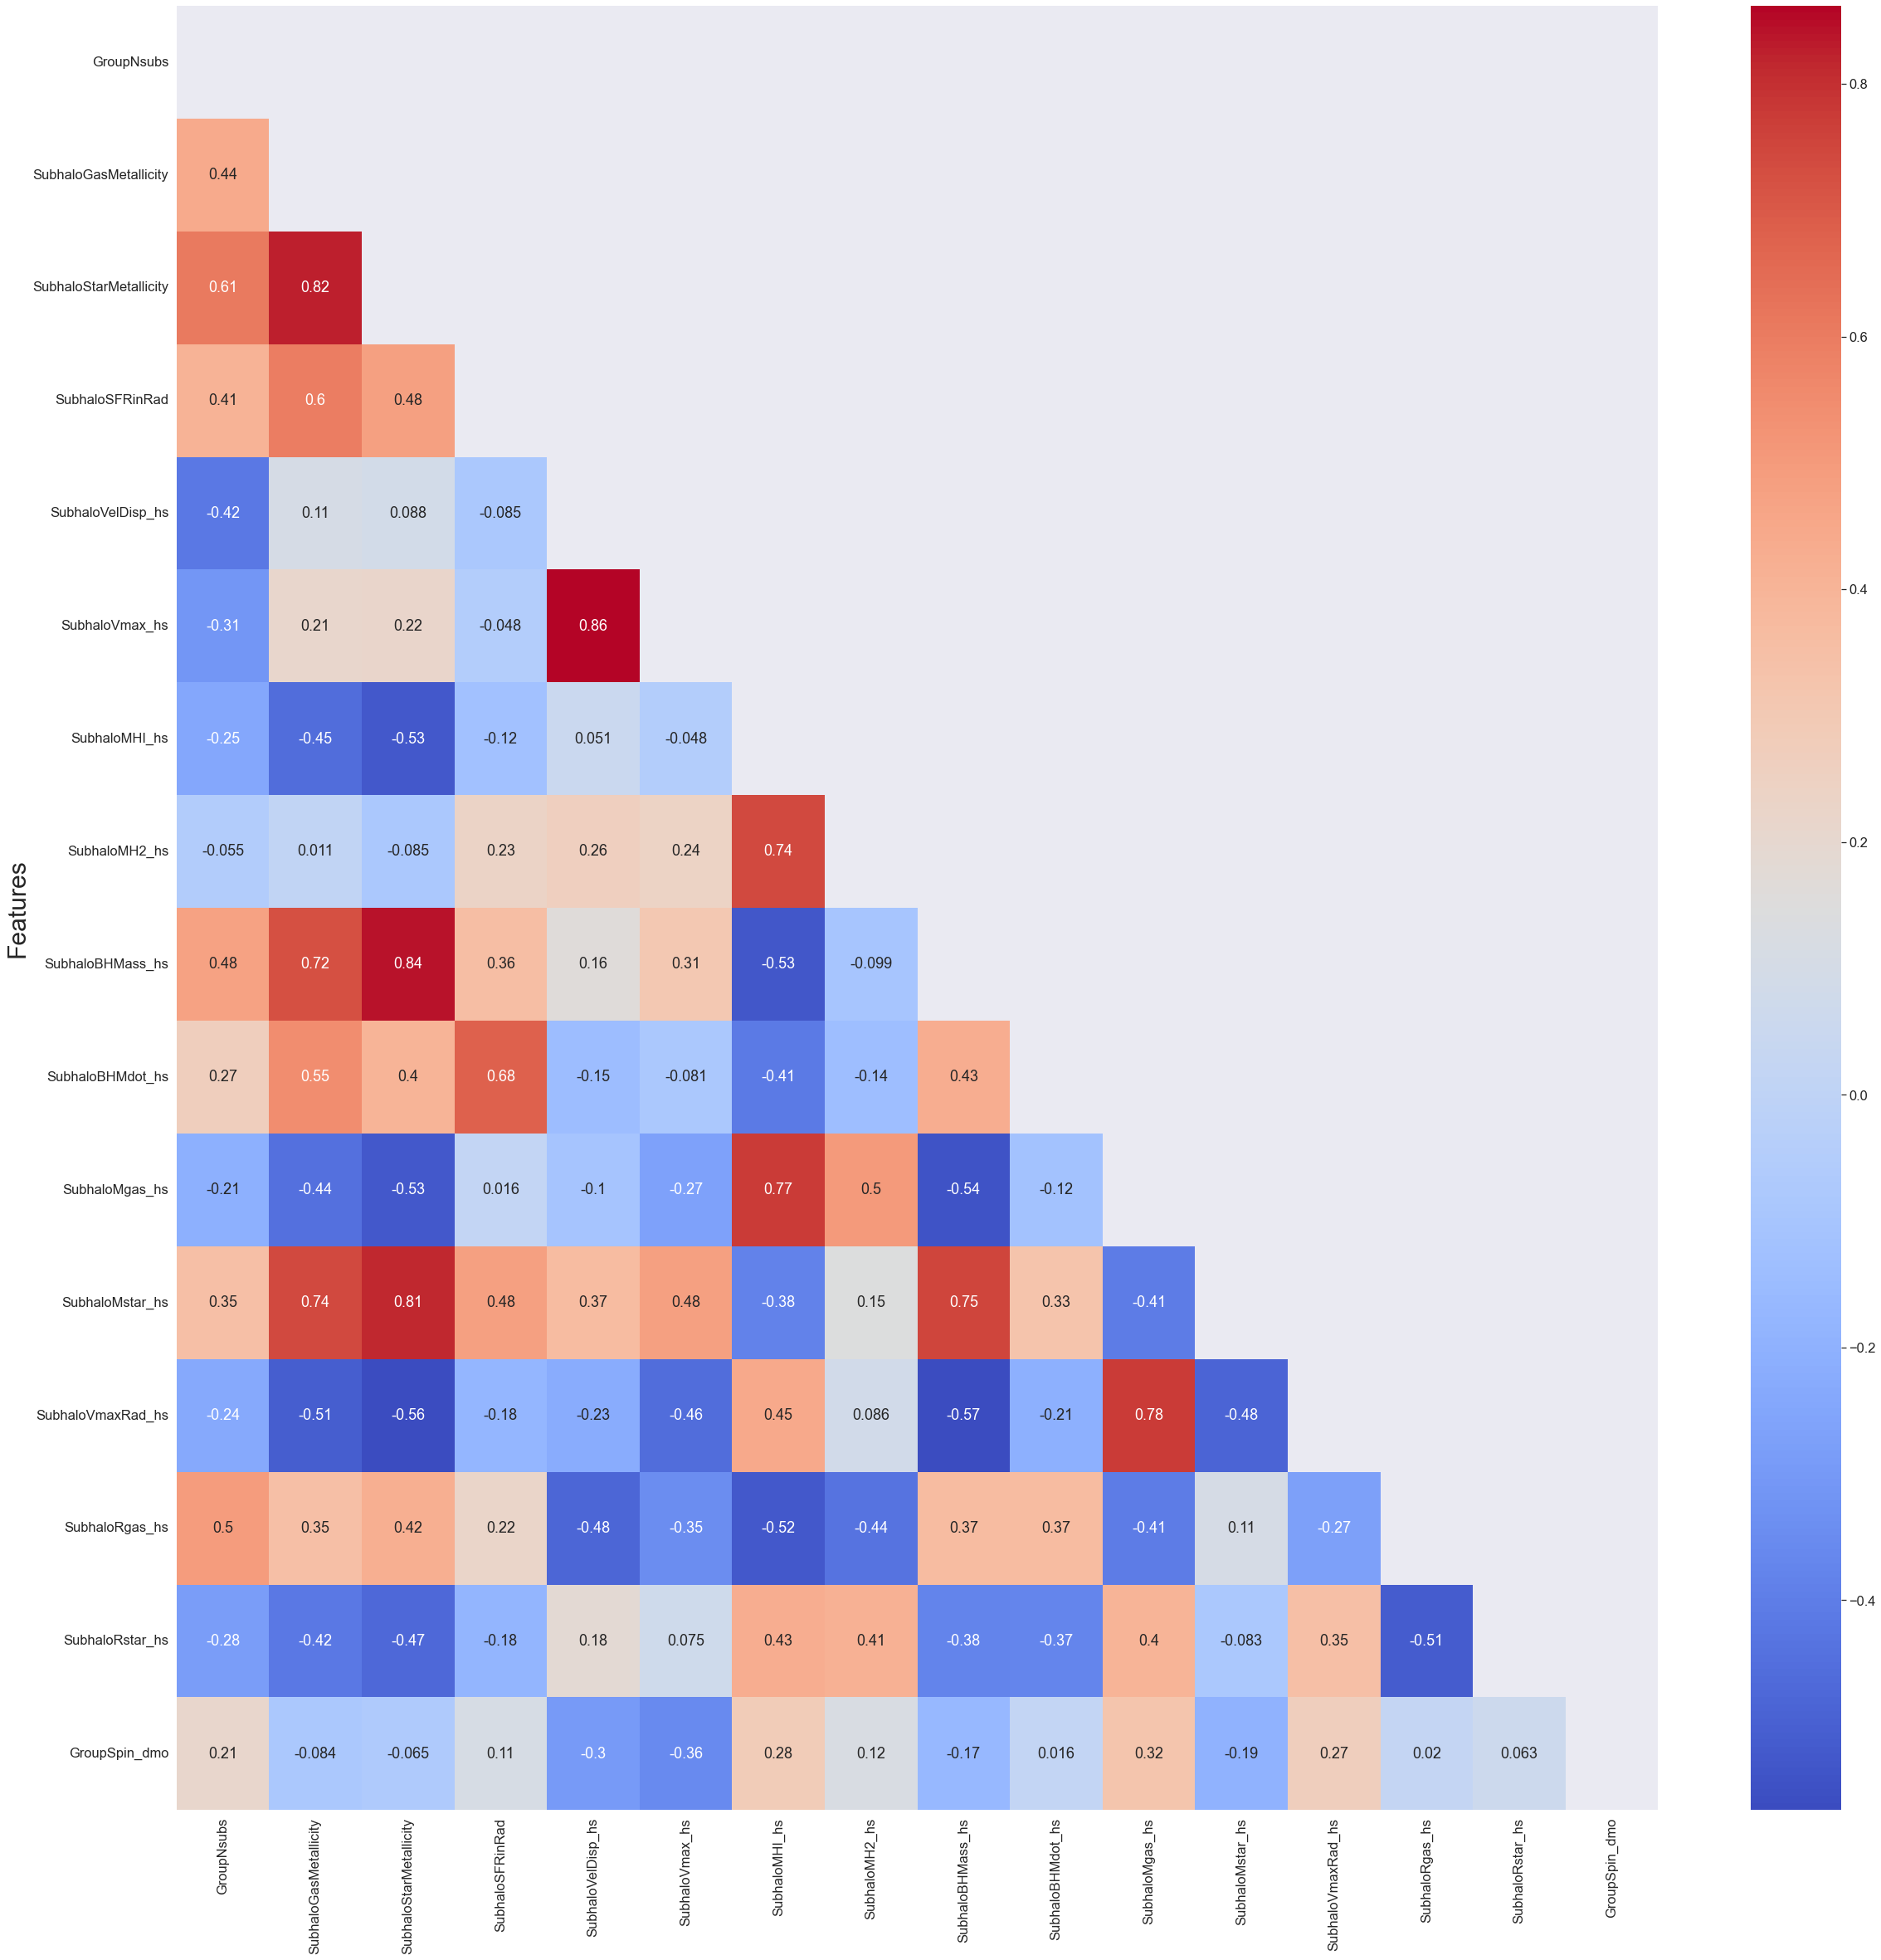

In [30]:
corr_df_0D = df_centrals_0D_arranged.corr('spearman')
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df_0D) # take upper correlation matrix
sns.heatmap(corr_df_0D,annot=True, mask=matrix, cmap="coolwarm", annot_kws={"size": 18}) #,
#             xticklabels=new_names, yticklabels=new_names)

# Q: How to change feature names from the ones in df_centrals_raw to paper names?

sns.set(font_scale=1.5)
# plt.title("Spearman Correlation of Raw TNG-SIM \n v3 Dataset w log10Mstar=8 gals included", fontsize = 20)
plt.ylabel("Features", fontsize = 30)
# plt.savefig('TNG-SIM_images/v14_updated_analysis/v14_TNG-SIM_Spearman_correlation_0D_dataset.jpeg', dpi=500)
plt.show()
